In [1]:
# Libraries Import

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import jieba
from janome.tokenizer import Tokenizer
from pythainlp.tokenize import word_tokenize as thai_tokenize

In [2]:
# Path Configuration

LANGS_PATH = "./data/raw/langs.txt"
RAW_PATH = "./data/raw/sentences.csv"
PROCESSED_DIR = "./data/processed"
MODEL_PATH = "./models/lang_detect.ftz"
TRAIN_PATH = "./data/processed/train.txt"
TEST_PATH = "./data/processed/test.txt"
VALID_PATH = "./data/processed/valid.txt"

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs("./models", exist_ok=True)

In [3]:
# Data Cleaning

TARGET_LANGS = []

try:
    with open(LANGS_PATH, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip() and "," in line:
                code = line.strip().split(",", 1)[0].strip()
                TARGET_LANGS.append(code)
except FileNotFoundError:
    print(f"Error: File not found at {LANGS_PATH}")
    raise

try:
    df = pd.read_csv(RAW_PATH, sep="\t", header=None, names=["id", "lang", "text"], quoting=3)
except FileNotFoundError:
    print(f"Error: File not found at {RAW_PATH}")
    raise

df = df[df['lang'].isin(TARGET_LANGS)]

In [4]:
# Data Preprocessing: Tokenization

# Function only
jpn_tokenizer = Tokenizer()

def tokenize(text, lang):
    try:
        if lang == "cmn":
            return " ".join(jieba.lcut(text))
        elif lang == "jpn":
            return " ".join([t.surface for t in jpn_tokenizer.tokenize(text)])
        elif lang == "tha":
            return " ".join(thai_tokenize(text))
        else:
            return text
    except:
        return text

In [ ]:
# Data Balancing and Formatting

MAX_SAMPLES_PER_LANG = 20000

df_balanced = (
    df.groupby("lang", group_keys=False)
    .apply(
        lambda x: x.sample(n=min(len(x), MAX_SAMPLES_PER_LANG), random_state=42),
        include_groups=False
    )
    .reset_index(drop=True)
)

# Tokenize after filtering the samples
df["text"] = df.apply(lambda row: tokenize(str(row["text"]), row["lang"]), axis=1)

df_balanced['formatted'] = '__label__' + df_balanced['lang'] + ' ' + df_balanced['text']
lines = df_balanced['formatted'].tolist()

random.seed(42)
random.shuffle(lines)

with open(os.path.join(PROCESSED_DIR, "lang_dataset.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(lines))


Original Distribution:
lang
eng    1984147
rus    1136949
ita     928445
epo     792549
kab     766828
        ...   
bua       1062
gla       1050
sdh       1050
rom       1042
ltz       1022
Name: count, Length: 136, dtype: int64

Balanced Distribution:
lang
hau    20000
heb    20000
jpn    20000
lat    20000
fin    20000
       ...  
bua     1062
gla     1050
sdh     1050
rom     1042
ltz     1022
Name: count, Length: 136, dtype: int64


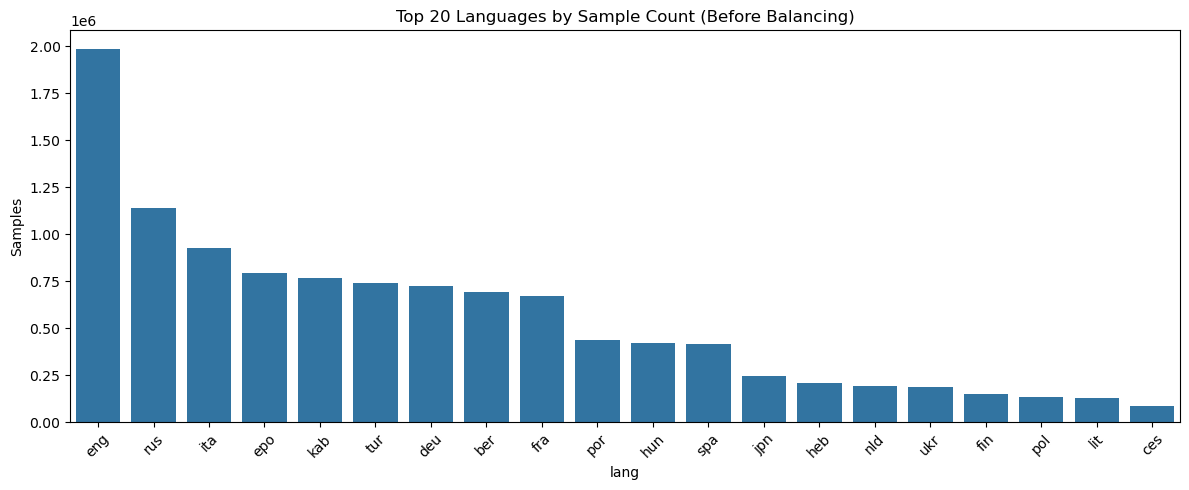

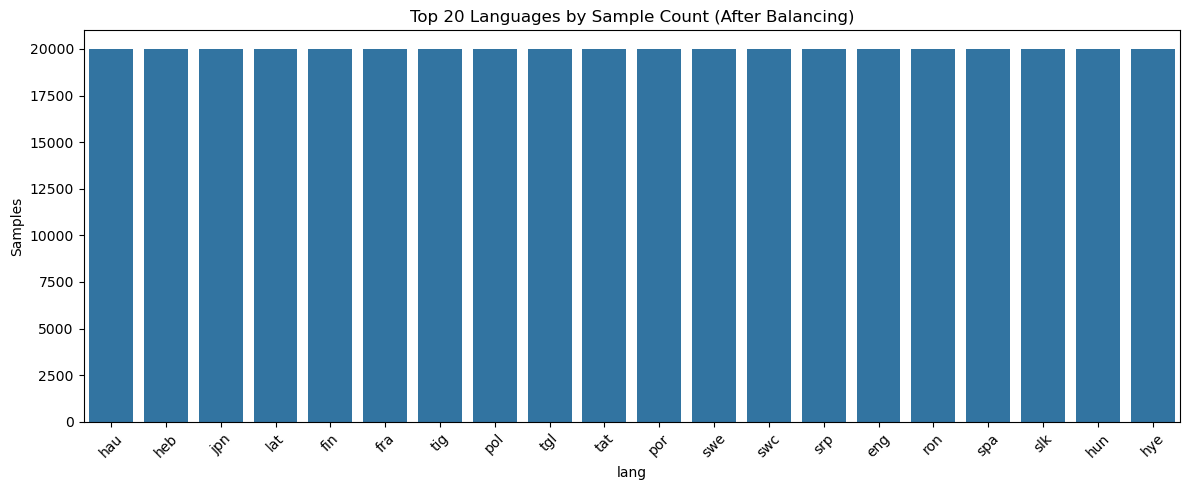

In [10]:
# Exploratory Data Analysis (EDA)

# Distributions
print("\nOriginal Distribution:")
print(df['lang'].value_counts())

print("\nBalanced Distribution:")
print(df_balanced['lang'].value_counts())

# Sample counts
plt.figure(figsize=(12, 5))
sns.barplot(x=df['lang'].value_counts().index[:20], y=df['lang'].value_counts().values[:20])
plt.title("Top 20 Languages by Sample Count (Before Balancing)")
plt.ylabel("Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x=df_balanced['lang'].value_counts().index[:20], y=df_balanced['lang'].value_counts().values[:20])
plt.title("Top 20 Languages by Sample Count (After Balancing)")
plt.ylabel("Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Data Split

train, testval = train_test_split(lines, test_size=0.3, random_state=42)
test, valid = train_test_split(testval, test_size=1/3, random_state=42)

with open(os.path.join(PROCESSED_DIR, "train.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(train))
with open(os.path.join(PROCESSED_DIR, "test.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(test))
with open(os.path.join(PROCESSED_DIR, "valid.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(valid))

In [8]:
# Model Training

model = fasttext.train_supervised(
    input=TRAIN_PATH,
    epoch=10,
    lr=0.3,
    wordNgrams=2,
    minCount=2,
    loss='softmax',
    dim=100,
    verbose=2
)

model.save_model(MODEL_PATH)

In [9]:
# Model Evaluation

def evaluate(dataset_path, name):
    result = model.test(dataset_path)
    print(f"\n Evaluation on {name.upper()} set:")
    print(f"  Samples  : {result[0]}")
    print(f"  Precision: {result[1]:.4f}")
    print(f"  Recall   : {result[2]:.4f}")

evaluate(TRAIN_PATH, "train")
evaluate("./data/processed/test.txt", "test")
evaluate("./data/processed/valid.txt", "validation")

true_labels = []
pred_labels = []

with open("./data/processed/test.txt", "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        label, text = line.strip().split(" ", 1)
        true = label.replace("__label__", "")
        pred = model.predict(text)[0][0].replace("__label__", "")
        true_labels.append(true)
        pred_labels.append(pred)

labels = sorted(list(set(true_labels + pred_labels)))

print("\n📄 Classification Report:")
print(classification_report(true_labels, pred_labels, labels=labels))


 Evaluation on TRAIN set:
  Samples  : 1015998
  Precision: 0.9988
  Recall   : 0.9988

 Evaluation on TEST set:
  Samples  : 290285
  Precision: 0.8904
  Recall   : 0.8904

 Evaluation on VALIDATION set:
  Samples  : 145143
  Precision: 0.8892
  Recall   : 0.8892

📄 Classification Report:
              precision    recall  f1-score   support

         afr       0.96      0.89      0.92       930
         alt       0.83      0.48      0.61       318
         ara       0.94      0.89      0.91      3940
         arq       0.89      0.65      0.75       474
         arz       0.90      0.46      0.61       289
         asm       0.99      0.94      0.96      2893
         avk       0.94      0.86      0.90       785
         aze       0.90      0.79      0.84      1203
         bel       0.93      0.89      0.91      2751
         ben       0.99      0.97      0.98      3207
         ber       0.79      0.74      0.76      3961
         bre       0.87      0.90      0.88      1593
     